# Imports


In [1]:
# System and OS utilities
import os, math, itertools, warnings, gc
from collections import defaultdict
from google.colab import drive
from os.path import join

# Data manipulation and processing
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import (
    ResNet50, EfficientNetB0, InceptionV3, InceptionResNetV2, DenseNet121
)
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M

# Scikit-learn for data preprocessing and splitting
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler

# Image processing
from PIL import Image

# Utility libraries
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
drive.mount('/content/drive')

# Load the images
DATA_ROOT = '/content/drive/MyDrive/Expanded_HHD_AgeSplit'

# Load the CSV file
csv_dir = os.path.join(DATA_ROOT, 'NewAgeSplit.csv')
labels_data = pd.read_csv(csv_dir)

Mounted at /content/drive


In [4]:
BATCH_SIZE = 64

# Training


## Loading Images and Preprocessing


In [5]:
def calculate_resized_dimensions(height, width, patch_size=400, stride=200, standard_size=800):
    """
    Calculates resized dimensions to maintain aspect ratio, be compatible with patching, and close to a standard size.

    Args:
        height (int): Original height of the image.
        width (int): Original width of the image.
        patch_size (int): Size of each patch (default 400).
        stride (int): Stride for patching (default 200).
        standard_size (int): Target standard size for the smaller dimension.

    Returns:
        tuple: Resized height and width.
    """
    aspect_ratio = width / height

    # Scale dimensions such that the smaller side matches the standard size
    if height < width:
        new_height = standard_size
        new_width = int(new_height * aspect_ratio)
    else:
        new_width = standard_size
        new_height = int(new_width / aspect_ratio)

    # Adjust dimensions to be compatible with patching
    def adjust_dimension(dim):
        remainder = (dim - patch_size) % stride
        return dim if remainder == 0 else dim - remainder

    new_height = adjust_dimension(new_height)
    new_width = adjust_dimension(new_width)

    return new_height, new_width

In [6]:
def read_tiff_image_with_dynamic_resize(img_path):
    """
    Reads a TIFF image, dynamically resizes it to be compatible with patches and standard size, and normalizes it.

    Args:
        img_path (tf.Tensor): Path to the image file.

    Returns:
        np.ndarray: Resized and normalized image as a NumPy array.
    """
    img = Image.open(img_path.numpy().decode("utf-8"))  # Load TIFF file
    img = img.convert('RGB')  # Convert to RGB if necessary
    original_size = img.size  # Original dimensions (width, height)
    new_height, new_width = calculate_resized_dimensions(original_size[1], original_size[0])
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)  # Resize dynamically with LANCZOS
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values
    return img_array

In [7]:
def process_image(row, root_dir, patch_size, step_size):
    """
    Processes a row to load the corresponding image, extract patches, and assign labels.

    Args:
        row (dict): Dictionary containing file path and label data.
        data_dir (str): Directory containing the images.
        patch_size (tuple): Size of each patch (height, width).
        step_size (int): Step size for extracting patches.

    Returns:
        tuple: Patches and corresponding labels.
    """
   # 1) turn the Python string into a tf.string scalar
    root = tf.constant(root_dir, dtype=tf.string)

    # 2) these are SymbolicTensors of dtype tf.string
    subset = row['Set']   # e.g. b'train'
    fname  = row['File']  # e.g. b'img123.tif'

    # 3) join them with TF ops, not os.path
    #    result is a tf.Tensor of dtype string like b'/…/HHD_AgeSplit/train/img123.tif'
    img_path = tf.strings.join([root, subset, fname], separator=os.path.sep)

    # 4) load & resize via py_function
    img = tf.py_function(
        func=read_tiff_image_with_dynamic_resize,
        inp=[img_path],
        Tout=tf.float32
    )
    img.set_shape([None, None, 3])   # preserve static rank

    # 5) extract patches
    patches = tf.image.extract_patches(
        images=tf.expand_dims(img, 0),
        sizes=[1, patch_size[0], patch_size[1], 1],
        strides=[1, step_size, step_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    patches = tf.reshape(patches, [-1, patch_size[0], patch_size[1], 3])

    # 6) labels
    labels = tf.fill([tf.shape(patches)[0]], row['Age'])

    # Compute mean intensity per patch, then mask out “empty” ones
    #    (mean over H, W, C → shape [num_patches])
    patch_means = tf.reduce_mean(patches, axis=[1, 2, 3])
    mask = patch_means > THR

    patches = tf.boolean_mask(patches, mask)
    labels  = tf.boolean_mask(labels,  mask)

    return patches, labels

In [8]:
# Create the RandomRotation layer outside the augmentation function.
rotation_layer = tf.keras.layers.RandomRotation(factor=0.04167)

def advanced_augmentation(image, label):
    # Apply random rotation using the pre-instantiated layer.
    image = rotation_layer(image, training=True)

    # Random Zoom: Scale the image by a factor between 0.9 and 1.1.
    orig_shape = tf.shape(image)[:2]
    zoom_factor = tf.random.uniform([], 0.9, 1.1)
    new_size = tf.cast(tf.cast(orig_shape, tf.float32) * zoom_factor, tf.int32)
    image = tf.image.resize(image, new_size)
    # Crop or pad back to the original dimensions.
    image = tf.image.resize_with_crop_or_pad(image, orig_shape[0], orig_shape[1])

    # Random Contrast (0.75–1.25)
    image = tf.image.random_contrast(image, lower=0.75, upper=1.25)

    # Gaussian Noise: Add noise with a standard deviation of 0.05.
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
    image = tf.clip_by_value(image + noise, 0., 1.)

    return image, label

In [9]:
def patch_data_tf_dataset_from_df(
    labels_df_subset,
    data_dir,
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
):
    """
    Like patch_data_tf_dataset, but draws from an arbitrary DataFrame slice
    instead of filtering by 'Set'. Useful for k-fold splits.

    Args:
        labels_df_subset (pd.DataFrame): Subset of labels_data for this fold.
        data_dir (str): Directory containing images (train/val/test all the same).
        patch_size (tuple): Patch height & width.
        step_size (int): Stride for patches.
        batch_size (int): tf.data batch size.
        augment (bool): Whether to apply advanced_augmentation.

    Returns:
        tf.data.Dataset: Batched dataset of (patch, label) pairs.
    """
    ds = tf.data.Dataset.from_tensor_slices(dict(labels_df_subset))
    ds = ds.map(
        lambda row: process_image(row, data_dir, patch_size, step_size),
        num_parallel_calls=tf.data.AUTOTUNE
    ).flat_map(
        lambda patches, labels: tf.data.Dataset.zip((
            tf.data.Dataset.from_tensor_slices(patches),
            tf.data.Dataset.from_tensor_slices(labels)
        ))
    )
    if augment:
        ds = ds.map(
            lambda img, lbl: advanced_augmentation(img, lbl),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
# Define a function to create models using SOTA architectures
def build_sota_model(base_model_fn, input_shape=(400, 400, 3), dropout_rate=0.5):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)  # Regression output

    model = Model(inputs, outputs)
    return model

In [11]:
# if 'mean_patch_intensity' not in CACHE:
#     train_data = labels_data[labels_data['Set'] == 'train']
#     sample_files = train_data.sample(n=200, random_state=42)['File']
#     vals = []
#     for f in sample_files:
#         # Convert the file path string to a TensorFlow constant before passing it
#         # to the tf.py_function wrapped function.
#         arr = read_tiff_image_with_dynamic_resize(tf.constant(os.path.join(train_dir, f)))
#         vals.append(arr.mean())
#     CACHE['mean_patch_intensity'] = np.mean(vals)
THR = 0.0054
print(f"Empty-patch threshold set to {THR:.4f}")

Empty-patch threshold set to 0.0054


## Train

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def compute_evaluation_metrics(true_images, predicted_images):
    """
    Computes evaluation metrics for age prediction models.

    Args:
        true_images (np.ndarray): Array of true ages grouped by image ID.
        predicted_images (np.ndarray): Array of predicted ages grouped by image ID.

    Returns:
        dict: A dictionary containing various evaluation metrics.
    """
    # Compute primary metrics
    mae = mean_absolute_error(true_images, predicted_images)
    rmse = np.sqrt(mean_squared_error(true_images, predicted_images))
    r2 = r2_score(true_images, predicted_images)
    mape = np.mean(np.abs((true_images - predicted_images) / true_images)) * 100

    # Threshold calculations
    def percent_within_threshold(y_true, y_pred, threshold):
        errors = np.abs(y_true - y_pred)
        within = np.sum(errors <= threshold)
        return (within / len(y_true)) * 100

    within_2 = percent_within_threshold(true_images, predicted_images, 2)
    within_5 = percent_within_threshold(true_images, predicted_images, 5)
    within_10 = percent_within_threshold(true_images, predicted_images, 10)

    # Additional statistics
    errors = np.abs(true_images - predicted_images)
    max_error = np.max(errors)
    median_error = np.median(errors)
    cumulative_error_5 = np.mean(errors <= 5) * 100

    # Compile metrics
    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Within ±2 Years (%)": within_2,
        "Within ±5 Years (%)": within_5,
        "Within ±10 Years (%)": within_10,
        "Max Error": max_error,
        "Median Error": median_error,
        "Cumulative Error ≤ 5 Years (%)": cumulative_error_5,
    }

    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")


    # Create plots
    errors_sorted = np.sort(errors)
    cumulative_percentage = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Error Distribution Plot
    axs[0].hist(errors, bins=20, edgecolor='black')
    axs[0].set_title('Error Distribution')
    axs[0].set_xlabel('Prediction Error (Years)')
    axs[0].set_ylabel('Frequency')

    # Cumulative Error Distribution Plot
    axs[1].plot(errors_sorted, cumulative_percentage)
    axs[1].set_title('Cumulative Error Distribution')
    axs[1].set_xlabel('Absolute Error (Years)')
    axs[1].set_ylabel('Cumulative Percentage (%)')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return metrics

In [13]:
# Group predictions by 'File' (ImageID)
def group_predictions_by_image_id(predictions_with_ids, labels_df):
    """
    Groups predictions by their `image_id`.
    Args:
        predictions_with_ids (list): List of tuples (prediction, image_id).
        labels_df (pd.DataFrame): DataFrame containing true labels.
    Returns:
        tuple: Grouped predictions and true labels for each image.
    """
    grouped_predictions = defaultdict(list)
    grouped_labels = defaultdict(list)

    # Group predictions by `image_id`
    for pred, image_id in predictions_with_ids:
        # If image_id is bytes, decode; otherwise, use as-is.
        if isinstance(image_id, bytes):
            image_id_str = image_id.decode('utf-8')
        else:
            image_id_str = image_id
        grouped_predictions[image_id_str].append(pred)

    # Match true labels from `labels_df`
    for _, row in labels_df.iterrows():
        file_id = row['File']
        if file_id in grouped_predictions:
            grouped_labels[file_id].append(row['Age'])

    # Filter to only include image IDs present in both predictions and labels
    common_ids = set(grouped_predictions.keys()) & set(grouped_labels.keys())

    predicted_images = [np.mean(grouped_predictions[img_id]) for img_id in common_ids]
    true_images = [np.mean(grouped_labels[img_id]) for img_id in common_ids]

    return np.array(predicted_images), np.array(true_images)

In [14]:
def process_row_with_id(row):
    """
    Processes a row to generate patches, labels, and use 'File' as the ImageID.
    """
    # Load patches and labels, pointing at the base HHD_AgeSplit folder
    patches, labels = process_image(row, DATA_ROOT, (400,400), 200)

    # Use 'File' as the ImageID
    image_id = tf.fill([tf.shape(patches)[0]], row['File'])
    return patches, labels, image_id

In [15]:
def patch_data_tf_dataset_with_ids_from_df(
    df_subset,
    data_dir,
    patch_size=(400, 400),
    step_size=200,
    batch_size=128,
    augment=False,
):
    """
    Like patch_data_tf_dataset_with_ids() but takes _any_ DataFrame slice –
    perfect for k-fold splits where val rows are no longer ‘val’ in Set.
    Yields (patch, label, image_id) batched.
    """
    ds = (
        tf.data.Dataset.from_tensor_slices(dict(df_subset))
        .map(process_row_with_id, num_parallel_calls=tf.data.AUTOTUNE)   # ➜ (patches, labels, image_ids)
        .flat_map(
            lambda patches, labels, image_ids: tf.data.Dataset.zip(
                (
                    tf.data.Dataset.from_tensor_slices(patches),
                    tf.data.Dataset.from_tensor_slices(labels),
                    tf.data.Dataset.from_tensor_slices(image_ids),
                )
            )
        )
    )

    if augment:
        ds = ds.map(
            lambda p, l, i: (tf.image.random_flip_left_right(p), l, i),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
def make_sgkf_splits(df: pd.DataFrame, n_splits=5, random_state=42):
    """
    Returns a list of (train_idx, val_idx) tuples produced by
    StratifiedGroupKFold on writer-level records.

    •  Stratification key  →  AgeGroup
    •  Group key           →  WriterNumber
    """
    sgkf = StratifiedGroupKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    # NOTE: splitter expects X, y, groups
    X      = df.index.values
    y      = df['AgeGroup'].values
    groups = df['WriterNumber'].values

    return list(sgkf.split(X, y, groups))

In [17]:
def run_cv(
    df_full: pd.DataFrame,
    base_model_fn,
    model_name: str,
    n_splits: int = 5,
    epochs_init: int = 50,
    epochs_ft: int = 10,
    batch_size: int = 64,
    patch_size=(400,400),
    step_size=200,
    dropout=0.5,
):
    # 1) prepare folds
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    splits = list(sgkf.split(df_full.index, df_full["AgeGroup"], df_full["WriterNumber"]))
    ckpt_dir = os.path.join(DATA_ROOT, "CV_STRAT_GROUP", model_name)
    os.makedirs(ckpt_dir, exist_ok=True)

    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(splits, start=1):
        if model_name in ("ResNet50", "DenseNet121"):
            if fold in (1,5):
                continue

        print(f"\n── {model_name} Fold {fold}/{n_splits} ──")

        # === 2) slice dataframes ===
        train_df = df_full.iloc[train_idx].reset_index(drop=True)
        val_df   = df_full.iloc[val_idx].reset_index(drop=True)

        # === 3) make datasets ===
        train_ds = patch_data_tf_dataset_from_df(
            train_df, DATA_ROOT,
            patch_size=patch_size, step_size=step_size,
            batch_size=batch_size, augment=True
        )
        val_ds   = patch_data_tf_dataset_from_df(
            val_df, DATA_ROOT,
            patch_size=patch_size, step_size=step_size,
            batch_size=batch_size, augment=False
        )

        # === 4) build & warm-up train ===
        model = build_sota_model(base_model_fn,
                                 input_shape=(*patch_size,3),
                                 dropout_rate=dropout)
        backbone = model.layers[1]
        backbone.trainable = False
        model.compile(optimizer="adam", loss="mse", metrics=["mae"])

        ckpt_init = os.path.join(ckpt_dir, f"{model_name}_fold{fold}_init.keras")
        callbacks = [
            ModelCheckpoint(ckpt_init, monitor="val_mae", save_best_only=True, verbose=1),
            ReduceLROnPlateau(monitor="val_mae", factor=0.2, patience=4, verbose=1),
            EarlyStopping(    monitor="val_mae", patience=8, restore_best_weights=True, verbose=1),
        ]
        history = model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=epochs_init,
                            callbacks=callbacks,
                            verbose=2)

        # === 5) CLEANUP before fine-tune ===
        print("🧹 Clearing memory before fine-tune…")
        # delete large objects no longer needed
        del train_ds, val_ds, history, callbacks
        gc.collect()
        tf.keras.backend.clear_session()
        gc.collect()

        # === 6) rebuild model & load warm-up weights ===
        model = build_sota_model(base_model_fn,
                                 input_shape=(*patch_size,3),
                                 dropout_rate=dropout)
        model.load_weights(ckpt_init)
        backbone = model.layers[1]
        backbone.trainable = True
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                      loss="mse", metrics=["mae"])

        # === 7) re-create datasets for fine-tune ===
        train_ds = patch_data_tf_dataset_from_df(
            train_df, DATA_ROOT,
            patch_size=patch_size, step_size=step_size,
            batch_size=batch_size, augment=True
        )
        val_ds   = patch_data_tf_dataset_from_df(
            val_df, DATA_ROOT,
            patch_size=patch_size, step_size=step_size,
            batch_size=batch_size, augment=False
        )

        ckpt_ft = os.path.join(ckpt_dir, f"{model_name}_fold{fold}_ft.keras")
        callbacks = [
            ModelCheckpoint(ckpt_ft, monitor="val_mae", save_best_only=True, verbose=1),
            ReduceLROnPlateau(monitor="val_mae", factor=0.2, patience=4, verbose=1),
            EarlyStopping(    monitor="val_mae", patience=8, restore_best_weights=True, verbose=1),
        ]
        history_ft = model.fit(train_ds,
                               validation_data=val_ds,
                               epochs=epochs_ft,
                               callbacks=callbacks,
                               verbose=2)

        # === 8) EVALUATE (image-level) ===
        del train_ds, history_ft, callbacks    # free again before eval
        gc.collect()

        val_ids_ds = patch_data_tf_dataset_with_ids_from_df(
            val_df, DATA_ROOT,
            patch_size=patch_size, step_size=step_size,
            batch_size=batch_size, augment=False
        )
        preds = []
        for patches, _, img_ids in val_ids_ds:
            p = model.predict(patches, verbose=0).ravel()
            preds.extend(zip(p, img_ids.numpy()))

        y_pred_img, y_true_img = group_predictions_by_image_id(preds, val_df)
        metrics = compute_evaluation_metrics(y_true_img, y_pred_img)
        fold_metrics.append(metrics)

        # pretty-print
        keys = ["MAE","RMSE","R2","MAPE"]
        summary = " │ ".join(f"{k} {metrics[k]:.2f}" for k in keys if k in metrics)
        print(f"Fold {fold}: {summary}")

        # === 9) FINAL CLEANUP of this fold ===
        del val_ids_ds, preds, y_pred_img, y_true_img
        del train_df, val_df, model
        gc.collect()
        tf.keras.backend.clear_session()
        gc.collect()

    # === 10) AGGREGATE all folds ===
    print("\n══════ CV SUMMARY ══════")
    for k in fold_metrics[0].keys():
        arr = np.array([fm[k] for fm in fold_metrics], dtype=float)
        print(f"{k:<25}: {arr.mean():.2f} ± {arr.std():.2f}")

    return fold_metrics


── DenseNet121 Fold 2/5 ──
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mae improved from inf to 9.16425, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/DenseNet121/DenseNet121_fold2_init.keras
311/311 - 214s - 689ms/step - loss: 171.8519 - mae: 8.1055 - val_loss: 133.7115 - val_mae: 9.1643 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_mae improved from 9.16425 to 8.88648, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/DenseNet121/DenseNet121_fold2_init.keras
311/311 - 110s - 354ms/step - loss: 142.7874 - mae: 7.9397 - val_loss: 129.3735 - val_mae: 8.8865 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_mae improved from 8.88648 to 8.77337, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/DenseNet121/DenseNet121_fold2_init.keras
311/311 - 110s - 354ms/step - loss: 138.7825 - mae: 7.8041 - val_loss: 127.2872 - val_mae: 8.7734 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_mae did not improve from 8.77337
311/311 - 109s - 349ms/step - loss: 136

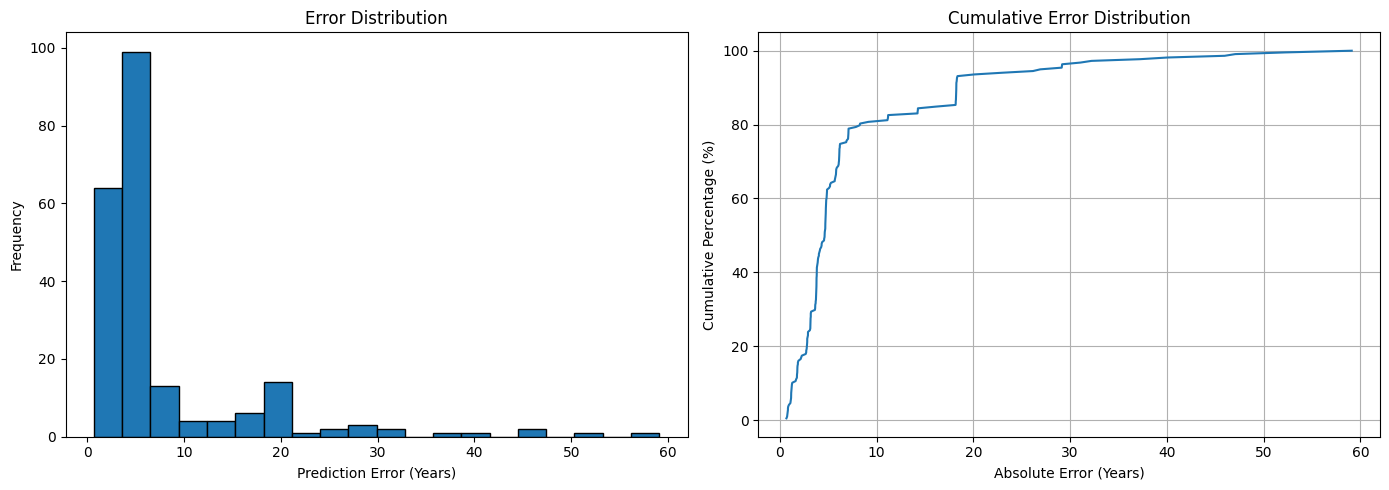

Fold 2: MAE 7.64 │ RMSE 11.98 │ R2 -0.11 │ MAPE 28.68

── DenseNet121 Fold 3/5 ──
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mae improved from inf to 10.23574, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/DenseNet121/DenseNet121_fold3_init.keras
292/292 - 172s - 588ms/step - loss: 164.8084 - mae: 7.8791 - val_loss: 174.7010 - val_mae: 10.2357 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_mae did not improve from 10.23574
292/292 - 106s - 362ms/step - loss: 119.3993 - mae: 7.4374 - val_loss: 173.5222 - val_mae: 10.2423 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_mae did not improve from 10.23574
292/292 - 106s - 362ms/step - loss: 116.4526 - mae: 7.3094 - val_loss: 173.0188 - val_mae: 10.2796 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_mae did not improve from 10.23574
292/292 - 105s - 360ms/step - loss: 114.5631 - mae: 7.2562 - val_loss: 173.3737 - val_mae: 10.3578 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_mae did not improve from 10.23574

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
292/292 - 10

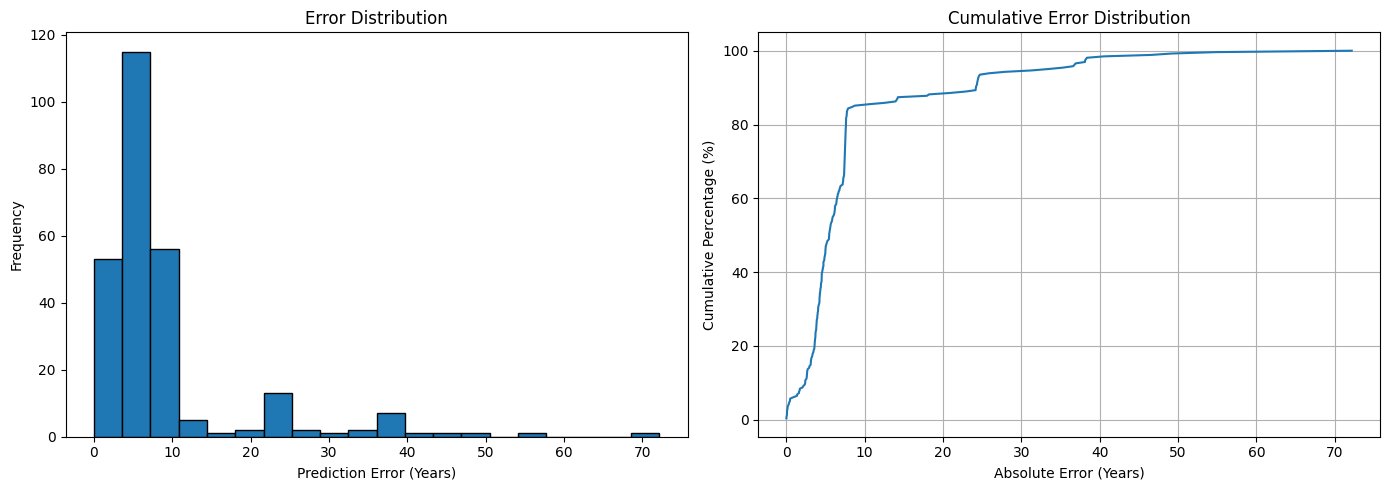

Fold 3: MAE 8.49 │ RMSE 13.15 │ R2 -0.06 │ MAPE 35.92

── DenseNet121 Fold 4/5 ──
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mae improved from inf to 9.46347, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/DenseNet121/DenseNet121_fold4_init.keras
318/318 - 178s - 560ms/step - loss: 188.9900 - mae: 8.5339 - val_loss: 134.9137 - val_mae: 9.4635 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_mae improved from 9.46347 to 9.34531, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/DenseNet121/DenseNet121_fold4_init.keras
318/318 - 111s - 349ms/step - loss: 145.3726 - mae: 8.1275 - val_loss: 131.7716 - val_mae: 9.3453 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_mae improved from 9.34531 to 9.27565, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/DenseNet121/DenseNet121_fold4_init.keras
318/318 - 110s - 347ms/step - loss: 142.0248 - mae: 8.0088 - val_loss: 129.7365 - val_mae: 9.2757 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_mae improved from 9.27565 to 9.26820, saving model to /content/drive/MyD

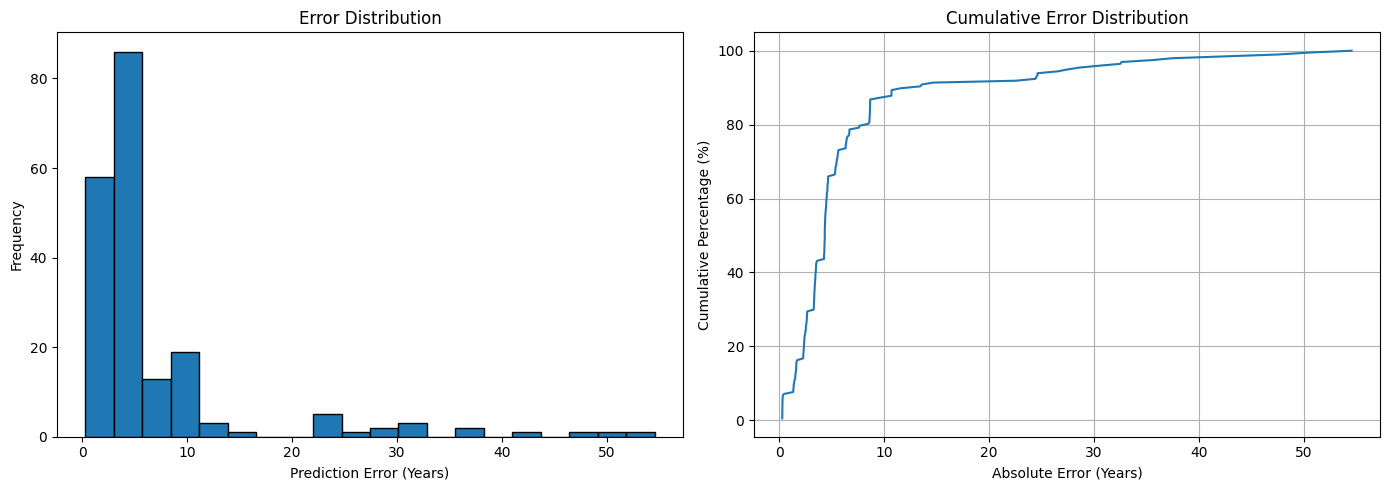

Fold 4: MAE 6.84 │ RMSE 11.32 │ R2 -0.08 │ MAPE 26.95

══════ CV SUMMARY ══════
MAE                      : 7.66 ± 0.67
RMSE                     : 12.15 ± 0.76
R2                       : -0.08 ± 0.02
MAPE                     : 30.51 ± 3.88
Within ±2 Years (%)      : 13.57 ± 3.66
Within ±5 Years (%)      : 58.19 ± 8.61
Within ±10 Years (%)     : 84.39 ± 2.73
Max Error                : 61.94 ± 7.46
Median Error             : 4.82 ± 0.47
Cumulative Error ≤ 5 Years (%): 58.19 ± 8.61

── InceptionV3 Fold 1/5 ──
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mae improved from inf to 19.72162, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/InceptionV3/InceptionV3_fold1_init.keras
329/329 - 156s - 474ms/step - loss: 133.8196 - mae: 7.2574 - val_loss: 459.2360 - val_mae: 19.7216 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_mae improved from 19.72162 to 18.65014, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/InceptionV3/InceptionV3_fold1_init.keras
329/329 - 108s - 330ms/step - loss: 121.9965 - mae: 7.1755 - val_loss: 414.9482 - val_mae: 18.6501 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_mae improved from 18.65014 to 17.97838, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/InceptionV3/InceptionV3_fold1_init.keras
329/329 - 109s - 331ms/step - loss: 117.8300 - mae: 7.1582 - val_loss: 388.8836 - val_mae: 17.9784 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_mae improved from 17.97838 to 17.73514, saving model to /content

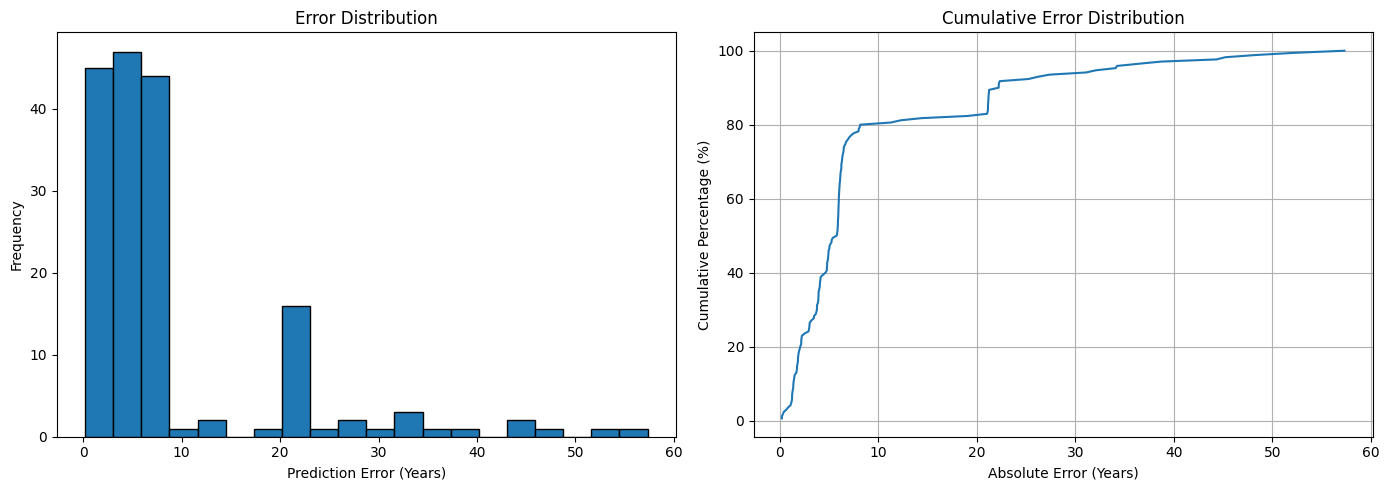

Fold 1: MAE 8.85 │ RMSE 13.88 │ R2 -0.13 │ MAPE 30.65

── InceptionV3 Fold 2/5 ──
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_mae improved from inf to 21.29623, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/InceptionV3/InceptionV3_fold2_init.keras
311/311 - 135s - 434ms/step - loss: 151.0906 - mae: 7.7056 - val_loss: 539.1796 - val_mae: 21.2962 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_mae improved from 21.29623 to 20.07268, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/InceptionV3/InceptionV3_fold2_init.keras
311/311 - 105s - 338ms/step - loss: 135.7429 - mae: 7.6106 - val_loss: 484.6169 - val_mae: 20.0727 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_mae improved from 20.07268 to 19.53250, saving model to /content/drive/MyDrive/Expanded_HHD_AgeSplit/CV_STRAT_GROUP/InceptionV3/InceptionV3_fold2_init.keras
311/311 - 105s - 338ms/step - loss: 128.0099 - mae: 7.5427 - val_loss: 462.4807 - val_mae: 19.5325 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_mae improved from 19.53250 to 19.07839, saving model to /content

In [ ]:
# Define SOTA models
models = {
    # 'ResNet50': ResNet50,
    'DenseNet121': DenseNet121,
    'InceptionV3': InceptionV3,
    'InceptionResNetV2': InceptionResNetV2,
    'EfficientNetV2M': EfficientNetV2M
}

df_full = pd.read_csv(csv_dir)

cv_stats = {}
for name, fn in models.items():
    cv_stats[name] = run_cv(
        df_full = df_full,
        base_model_fn = fn,
        model_name    = name,
        n_splits      = 5,
        batch_size    = 64,
    )

print(cv_stats)

In [ ]:
# ========= Minimum-Error Metric across Folds =========
import gc
from sklearn.model_selection import StratifiedGroupKFold

min_error_stats = {}     # {model_name: (mean, std)}

# 1) Re-create the CV splitter exactly as in run_cv
sgkf   = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(sgkf.split(df_full.index,
                         df_full["AgeGroup"],
                         df_full["WriterNumber"]))

print("\n══════ Minimum Absolute Error per Model ══════")
for model_name in models.keys():
    fold_min_errors = []

    for fold, (_, test_idx) in enumerate(splits, start=1):
        # --- load the fine-tuned checkpoint for this fold ---
        ckpt_path = os.path.join(
            DATA_ROOT, "CV_STRAT_GROUP", model_name,
            f"{model_name}_fold{fold}_ft.keras"
        )
        # try to load finetuned model, if not existent, fallback to init trained model
        if not os.path.exists(ckpt_path):
            ckpt_path = os.path.join(
                DATA_ROOT, "CV_STRAT_GROUP", model_name,
                f"{model_name}_fold{fold}_init.keras"
            )
        model = tf.keras.models.load_model(ckpt_path, compile=False)

        # --- prepare this fold’s *test* data ---
        test_df = df_full.iloc[test_idx].reset_index(drop=True)
        test_ds = patch_data_tf_dataset_with_ids_from_df(
            test_df, DATA_ROOT,
            patch_size=(400, 400), step_size=200,
            batch_size=64, augment=False
        )

        # --- run inference & aggregate to image-level ---
        preds = []
        for patches, _, img_ids in test_ds:
            p = model.predict(patches, verbose=0).ravel()
            preds.extend(zip(p, img_ids.numpy()))

        y_pred_img, y_true_img = group_predictions_by_image_id(preds, test_df)

        # --- compute this fold’s *minimum* absolute error ---
        abs_errors = np.abs(np.array(y_pred_img) - np.array(y_true_img))
        fold_min_errors.append(abs_errors.min())

        # --- tidy up memory before next fold ---
        del model, test_ds, preds, y_pred_img, y_true_img, abs_errors
        gc.collect()
        tf.keras.backend.clear_session()
        gc.collect()

    # store & display results for this model
    mean_min = np.mean(fold_min_errors)
    std_min  = np.std(fold_min_errors)
    min_error_stats[model_name] = (mean_min, std_min)
    print(f"{model_name:<15}: {mean_min:.2f} ± {std_min:.2f}")

# min_error_stats now holds the summarised metric if you need it later


# Evaluation


## Methods

In [ ]:
def patch_data_tf_dataset_with_ids(
    data_dir, labels_df, dataset_type, patch_size=(400, 400), step_size=200, batch_size=BATCH_SIZE, augment=False
):
    """
    Creates a TensorFlow dataset with patches and 'File' as ImageID.
    """
    subset_df = labels_df[labels_df['Set'] == dataset_type].reset_index(drop=True)
    dataset = tf.data.Dataset.from_tensor_slices(dict(subset_df))

    # Map the function to process rows
    dataset = dataset.map(
        process_row_with_id,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Flatten dataset to yield individual patches
    dataset = dataset.flat_map(
        lambda patches, labels, image_id: tf.data.Dataset.zip(
            (
                tf.data.Dataset.from_tensor_slices(patches),
                tf.data.Dataset.from_tensor_slices(labels),
                tf.data.Dataset.from_tensor_slices(image_id) # Keep image_id here
            )
        )
    )

    # Apply augmentation if required
    if augment:
        dataset = dataset.map(
            lambda patch, label, image_id: (tf.image.random_flip_left_right(patch), label, image_id),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def ensemble_predict(models, test_data):
    """
    Makes predictions using an ensemble of models by averaging their outputs.
    Args:
        models (dict): A dictionary of trained models.
        test_data (tf.data.Dataset): Test dataset.
    Returns:
        list: A list of tuples containing predictions and image IDs.
    """
    predictions = []
    for batch in test_data:
        patches, _, image_ids = batch

        batch_preds = [model.predict(patches, verbose=0) for model in models.values()]
        avg_preds = np.mean(batch_preds, axis=0)
        predictions.extend(zip(avg_preds.flatten(), image_ids.numpy()))

    return predictions

In [ ]:
def ensemble_predict_with_weights(models, test_data, weights=None):
    """
    Makes predictions using an ensemble of models by computing a weighted average of their outputs.

    Args:
        models (dict): A dictionary of trained models.
        test_data (tf.data.Dataset): Test dataset.
        weights (dict, optional): A dictionary mapping model names to their weights.
                                  If None, each model is given equal weight.

    Returns:
        list: A list of tuples containing the weighted average predictions and image IDs.
    """
    predictions = []

    # If no weights provided, assign equal weights to all models.
    if weights is None:
        weights = {name: 1.0 for name in models.keys()}

    # Normalize weights so they sum to 1.
    total_weight = sum(weights.values())
    normalized_weights = {name: weight / total_weight for name, weight in weights.items()}

    for batch in test_data:
        patches, _, image_ids = batch

        # Initialize weighted predictions with zeros.
        batch_preds_weighted = np.zeros((patches.shape[0], 1))

        # Accumulate predictions from each model multiplied by its normalized weight.
        for model_name, model in models.items():
            model_weight = normalized_weights.get(model_name, 0)
            preds = model.predict(patches, verbose=0)
            batch_preds_weighted += model_weight * preds

        # Append weighted predictions along with corresponding image IDs.
        predictions.extend(zip(batch_preds_weighted.flatten(), image_ids.numpy()))

    return predictions

In [ ]:
def evaluate_individual_model(model, test_dataset, labels_df):
    """
    Evaluates a single model's performance on a test dataset, grouping predictions by image ID.

    Args:
        model (tf.keras.Model): The trained model to evaluate.
        test_dataset (tf.data.Dataset): Dataset containing test patches, labels, and image IDs.
        labels_df (pd.DataFrame): DataFrame with true labels and file IDs.

    Returns:
        dict: Evaluation metrics including MAE, RMSE, R², MAPE, and thresholds.
    """
    predictions_with_ids = []

    for batch in test_dataset:
        patches, _, image_ids = batch
        predictions = model.predict(patches, verbose=0).flatten()
        predictions_with_ids.extend(zip(predictions, image_ids.numpy()))

    predicted_images, true_images = group_predictions_by_image_id(predictions_with_ids, labels_df)

    return compute_evaluation_metrics(true_images, predicted_images)

## Load Models and Test Set


In [ ]:
trained_models = {}
model = 'InceptionV3'

for i in range(1,6):
    model_name = f'{model}_fold{i}'
    trained_models[model_name] = tf.keras.models.load_model(f'/content/drive/MyDrive/HHD_AgeSplit/cross_validation/{model}/{model_name}_finetune.keras')

In [ ]:
# subset your labels to the test rows
test_df = labels_data[labels_data['Set']=='test'].reset_index(drop=True)

test_dataset = patch_data_tf_dataset_with_ids(
    DATA_ROOT,         # root folder
    test_df,           # your subset DataFrame
    dataset_type='test',
    patch_size=(400,400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
)

## Run Evaluations


### Ensemble Metrics

In [ ]:
# Generate predictions with image IDs
ensemble_predictions_with_ids = ensemble_predict(trained_models, test_dataset)

In [ ]:
# Group prediction by image
predicted_images, true_images = group_predictions_by_image_id(ensemble_predictions_with_ids, labels_data)

# Compute metrics
evaluation_metrics = compute_evaluation_metrics(true_images, predicted_images)

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import mean_absolute_error

def optimize_ensemble_weights(models, test_dataset, labels_df, search_space, start_index=0):
    """
    Searches over a grid of weight values for each model to find the combination
    that produces the lowest MAE on the given test dataset, starting from a specified index.

    Args:
        models (dict): Dictionary of trained models (keys are model names).
        test_dataset (tf.data.Dataset): Dataset yielding batches of (patches, labels, image_ids).
        labels_df (pd.DataFrame): DataFrame containing true labels with image IDs.
        search_space (dict): Dictionary mapping model names to a tuple (min, max, step) for weight search.
                             Example: {'ResNet50': (0.1, 0.5, 0.1), ...}
        start_index (int): The index of the weight combination from which to resume the grid search.

    Returns:
        tuple: (best_weights, best_mae)
            - best_weights (dict): Weight combination with the lowest MAE.
            - best_mae (float): Corresponding MAE value.
    """
    # Create lists of weight values for each model.
    weight_values = {
        model_name: np.arange(min_val, max_val + search_space[model_name][2], search_space[model_name][2])
        for model_name, (min_val, max_val, _) in search_space.items()
    }

    # Generate all weight combinations.
    all_combinations = list(itertools.product(*[weight_values[m] for m in weight_values]))

    best_weights = None
    best_mae = float('inf')

    total_combinations = len(all_combinations)
    print(f"Starting grid search with {total_combinations} combinations, resuming from index {start_index}.")

    # Resume from the specified start_index.
    for idx, combination in enumerate(all_combinations[start_index:], start=start_index):
        current_weights = dict(zip(weight_values.keys(), combination))
        # Skip combinations where the sum of weights is zero.
        if sum(current_weights.values()) == 0:
            continue

        # Compute ensemble predictions using the current weight combination.
        ensemble_preds_with_ids = ensemble_predict_with_weights(models, test_dataset, current_weights)
        predicted_images, true_images = group_predictions_by_image_id(ensemble_preds_with_ids, labels_df)
        mae = mean_absolute_error(true_images, predicted_images)

        print(f"Combination {idx+1}/{total_combinations} - Weights: {current_weights} => MAE: {mae:.2f}")

        if mae < best_mae:
            best_mae = mae
            best_weights = current_weights.copy()
            print(f"New best found: {best_weights} with MAE: {best_mae:.2f}")

    print(f"Best weights found: {best_weights} with MAE: {best_mae:.2f}")
    return best_weights, best_mae

# Example usage:
search_space = {
    'ResNet50': (0.1, 0.5, 0.1),
    'DenseNet121': (0.1, 0.5, 0.1),
    'InceptionResNetV2': (0.1, 0.5, 0.1)
}

# If your previous run stopped after processing 45 combinations, set start_index=45.
# best_weights, best_mae = optimize_ensemble_weights(trained_models, test_dataset, labels_data, search_space, start_index=85)
# best_weights, best_mae

In [ ]:
# weights = {
#     'ResNet50': 0.8,
#     # 'InceptionV3': 0.15,
#     # 'DenseNet121': 0.33,
#     # 'EfficientNetV2M': 0.1,
#     'InceptionResNetV2': 0.2
# }

In [ ]:
# Generate predictions with image IDs
# ensemble_predictions_with_ids = ensemble_predict_with_weights(trained_models, test_dataset, weights)

### Individual Model Metrics

In [ ]:
# Build a dictionary to store each model's predictions (after grouping by image ID)
model_predictions_dict = {}
true_ages = None  # Will be set once from the first model’s predictions

for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    predictions_with_ids = []

    # Iterate over the test dataset and gather predictions with image IDs
    for batch in test_dataset:
        patches, _, image_ids = batch
        preds = model.predict(patches, verbose=0).flatten()
        predictions_with_ids.extend(zip(preds, image_ids.numpy()))

    # Group predictions by image ID (returns (predicted_ages, true_ages))
    model_preds, model_true = group_predictions_by_image_id(predictions_with_ids, labels_data)

    # Store this model's predictions in the dictionary
    model_predictions_dict[model_name] = model_preds

    # Set true_ages once (assuming all models cover the same test set)
    if true_ages is None:
        true_ages = model_true

    # Optionally, compute and display individual evaluation metrics
    _ = compute_evaluation_metrics(model_true, model_preds)
    print("\n\n")

### Kappa

In [ ]:
def classify_age(age):
    """
    Classifies a continuous age value into one of four age groups.

    Args:
        age (float): The age value.

    Returns:
        int: Age group number (1 to 4).
            1: Age ≤ 15
            2: 16 ≤ Age ≤ 25
            3: 26 ≤ Age ≤ 50
            4: Age > 50
    """
    if age <= 15:
        return 1
    elif age <= 25:
        return 2
    elif age <= 50:
        return 3
    else:
        return 4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
from sklearn.metrics import confusion_matrix, cohen_kappa_score

def analyze_model_agreement(true_ages, model_predictions_dict, plot=True):
    """
    Analyzes agreement between models' age predictions.

    This function:
      1. Converts continuous predictions (and true ages) into categorical age groups
         using your standard `classify_age` function.
      2. Computes a confusion matrix (predicted vs. true categories) for each model.
      3. Computes pairwise Cohen's kappa scores between models to assess how similarly they predict.
      4. Optionally computes Fleiss' kappa for overall multi-model agreement.
      5. Optionally plots:
          - The confusion matrix for each model (with age group labels).
          - A heatmap of pairwise Cohen's kappa scores (with model names).

    Args:
        true_ages (np.ndarray): Array of true continuous ages.
        model_predictions_dict (dict): Dictionary where keys are model names and values are arrays
                                       of predicted continuous ages.
        plot (bool): Whether to generate plots.

    Returns:
        dict: Dictionary containing:
            - 'confusion_matrices': dict mapping each model name to its confusion matrix.
            - 'pairwise_kappa': 2D numpy array of pairwise Cohen's kappa scores.
            - 'model_names': List of model names (order corresponds to pairwise_kappa rows/columns).
            - 'fleiss_kappa': Fleiss' kappa score across all models (if computed, else None).
    """
    # Define the complete set of categorical labels
    labels_categories = [1, 2, 3, 4]

    # Convert true ages into categorical groups using classify_age
    true_categories = np.array([classify_age(age) for age in true_ages])

    # Compute confusion matrices for each model and store each model's categorical predictions.
    confusion_matrices = {}
    model_categories = {}
    for model_name, predictions in model_predictions_dict.items():
        # Convert continuous predictions into age groups using the same binning strategy.
        preds_categories = np.array([classify_age(age) for age in predictions])
        model_categories[model_name] = preds_categories

        # Warn if a model's predictions have only one unique category.
        unique_preds = np.unique(preds_categories)
        if len(unique_preds) == 1:
            print(f"Warning: Model {model_name} produced only one category: {unique_preds}")

        # Suppress warning from confusion_matrix about a single label by using a warnings context.
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="A single label was found in")
            cm = confusion_matrix(true_categories, preds_categories, labels=labels_categories)
        confusion_matrices[model_name] = cm

        if plot:
            # Plot the confusion matrix for the model.
            age_labels = ['<=15', '16-25', '26-50', '>50']
            plt.figure(figsize=(6, 5))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix - {model_name}')
            plt.colorbar()
            tick_marks = np.arange(len(age_labels))
            plt.xticks(tick_marks, age_labels)
            plt.yticks(tick_marks, age_labels)
            thresh = cm.max() / 2.0 if cm.max() > 0 else 1
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            plt.ylabel('True Age Groups')
            plt.xlabel('Predicted Age Groups')
            plt.tight_layout()
            plt.show()

    # Compute pairwise Cohen's kappa scores between models (using their categorical predictions).
    model_names = list(model_predictions_dict.keys())
    n_models = len(model_names)
    pairwise_kappa = np.zeros((n_models, n_models))
    for i in range(n_models):
        for j in range(n_models):
            if i == j:
                pairwise_kappa[i, j] = 1.0
            else:
                preds_i = model_categories[model_names[i]]
                preds_j = model_categories[model_names[j]]
                # If either prediction set has less than 2 unique values, assign 0.
                if len(np.unique(preds_i)) < 2 or len(np.unique(preds_j)) < 2:
                    kappa = 0.0
                else:
                    kappa = cohen_kappa_score(preds_i, preds_j, labels=labels_categories)
                    # If kappa is NaN, substitute with 0.
                    if np.isnan(kappa):
                        kappa = 0.0
                pairwise_kappa[i, j] = kappa

    if plot:
        # Plot heatmap of pairwise Cohen's kappa scores.
        plt.figure(figsize=(8, 6))
        plt.imshow(pairwise_kappa, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Pairwise Cohen's Kappa Between Models")
        plt.colorbar()
        tick_marks = np.arange(n_models)
        plt.xticks(tick_marks, model_names, rotation=45)
        plt.yticks(tick_marks, model_names)
        for i in range(n_models):
            for j in range(n_models):
                plt.text(j, i, f"{pairwise_kappa[i, j]:.2f}",
                         horizontalalignment="center",
                         color="white" if pairwise_kappa[i, j] > 0.5 else "black")
        plt.tight_layout()
        plt.show()

    # Compute Fleiss' Kappa for multi-model agreement (optional)
    # Prepare a ratings matrix: each row corresponds to a test instance,
    # and each column counts how many models predicted each age group.
    n_samples = len(true_categories)
    n_categories = len(labels_categories)
    ratings = np.zeros((n_samples, n_categories), dtype=int)
    for i in range(n_samples):
        for model_name in model_names:
            rating = model_categories[model_name][i]
            # Adjust index: category 1 -> index 0, etc.
            ratings[i, rating - 1] += 1
    try:
        from statsmodels.stats.inter_rater import fleiss_kappa
        fleiss = fleiss_kappa(ratings, method='fleiss')
    except ImportError:
        print("statsmodels is required for Fleiss' kappa. Skipping this metric.")
        fleiss = None

    results = {
        "confusion_matrices": confusion_matrices,
        "pairwise_kappa": pairwise_kappa,
        "model_names": model_names,
        "fleiss_kappa": fleiss
    }

    return results


# Now that all models have been evaluated, analyze the inter-model agreement
results = analyze_model_agreement(true_ages, model_predictions_dict, plot=True)

# Example output:
print("Pairwise Cohen's Kappa Matrix:")
print(results['pairwise_kappa'])
if results['fleiss_kappa'] is not None:
    print("Fleiss' Kappa (multi-model agreement):", results['fleiss_kappa'])

## Save image predictions to csv


In [ ]:
import os, csv
from collections import defaultdict
import tensorflow as tf

# 1️⃣ Configure these:
MODEL_NAMES = ['ResNet50','DenseNet121','InceptionV3','InceptionResNetV2','EfficientNetV2M']


FOLDS       = range(1, 6)
CKPT_ROOT   = '/content/drive/MyDrive/HHD_AgeSplit/cross_validation'
OUT_DIR     = '/content/drive/MyDrive/HHD_AgeSplit/cross_validation/image_level_preds'
os.makedirs(OUT_DIR, exist_ok=True)

# 2️⃣ Your test dataset generator (patch-level):
#    Must yield (patches, labels, image_ids) where image_ids are bytes strings.

# subset your labels to the test rows
test_df = labels_data[labels_data['Set']=='test'].reset_index(drop=True)

test_dataset = patch_data_tf_dataset_with_ids(
    DATA_ROOT,         # root folder
    test_df,           # your subset DataFrame
    dataset_type='test',
    patch_size=(400,400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
)

for model_name in MODEL_NAMES:
    for fold in FOLDS:
        print(f"\n→ Predicting {model_name} fold {fold}…")

        # — load the finetuned fold checkpoint
        ckpt_path = os.path.join(
            CKPT_ROOT,
            model_name,
            f"{model_name}_fold{fold}_finetune.keras"
        )
        model = tf.keras.models.load_model(ckpt_path)

        # — accumulate patch preds in a dict: { image_id → [pred1, pred2, …] }
        preds_per_image = defaultdict(list)
        for patches, _, image_ids in test_dataset:
            # shape (batch,1) → flatten to (batch,)
            preds = model.predict(patches, verbose=0).ravel()
            for img_id_bytes, p in zip(image_ids.numpy(), preds):
                img_id = img_id_bytes.decode('utf-8')
                preds_per_image[img_id].append(float(p))

        # — write image-level CSV for this fold (mean of its patches)
        csv_path = os.path.join(
            OUT_DIR,
            f"{model_name}_fold{fold}_image_preds.csv"
        )
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Model','Fold','ImageID','Image_Prediction'])
            for img_id, plist in preds_per_image.items():
                mean_pred = sum(plist) / len(plist)
                writer.writerow([model_name, fold, img_id, mean_pred])

        print(f"  ✔️ Saved {csv_path}")

        # — free GPU memory before next model/fold
        tf.keras.backend.clear_session()

In [ ]:
import glob
import pandas as pd

# 1️⃣ Grab all the image-level CSVs
pattern = os.path.join(OUT_DIR, '*_image_preds.csv')
files = glob.glob(pattern)

# 2️⃣ Read & concat
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

# 3️⃣ Ensemble by mean over all (Model,Fold) predictions per image
ensemble_df = (
    df
    .groupby('ImageID', as_index=False)['Image_Prediction']
    .mean()
    .rename(columns={'Image_Prediction':'Ensemble_Prediction'})
)

# 4️⃣ Save
ensemble_csv = os.path.join(OUT_DIR, 'ensemble_image_predictions.csv')
ensemble_df.to_csv(ensemble_csv, index=False)

print(f"✅ Ensemble saved to {ensemble_csv}")


In [ ]:
import os, numpy as np, pandas as pd
from collections import defaultdict

# --- Paths & constants --------------------------------------------------
OUT_DIR      = '/content/drive/MyDrive/HHD_AgeSplit/cross_validation/image_level_preds'
ENSEMBLE_CSV = os.path.join(OUT_DIR, 'ensemble_image_predictions.csv')
MODEL_NAMES = ['ResNet50','DenseNet121','InceptionV3','InceptionResNetV2','EfficientNetV2M']

FOLDS        = range(1, 6)

# --- True labels (image-level) ------------------------------------------
test_df  = labels_data[labels_data['Set'] == 'test'].reset_index(drop=True)
true_df  = test_df[['File', 'Age']].rename(columns={'File': 'ImageID',
                                                    'Age' : 'TrueAge'})

# =========================================================================
# 1) 𝙀𝙉𝙎𝙀𝙈𝘽𝙇𝙀 – all models & folds combined
# =========================================================================
ens_df      = pd.read_csv(ENSEMBLE_CSV)
ens_merged  = ens_df.merge(true_df, on='ImageID')
print("\n📊  Ensemble metrics (all models + folds)")
_ = compute_evaluation_metrics(ens_merged['TrueAge'].values,
                               ens_me   rged['Ensemble_Prediction'].values)

# =========================================================================
# 2) 𝙈𝙊𝘿𝙀𝙇-𝙇𝙀𝙑𝙀𝙇 𝙈𝙀𝙏𝙍𝙄𝘾𝙎 – mean ± std over its folds
# =========================================================================
print("\n──────── Individual models (mean ± std over folds) ────────")
for model_name in MODEL_NAMES:
    fold_mae = []
    preds_per_image = defaultdict(list)   # collect fold preds → model-level avg later

    for fold in FOLDS:
        csv_path = os.path.join(OUT_DIR,
                                f"{model_name}_fold{fold}_image_preds.csv")
        df_fold  = (pd.read_csv(csv_path)
                      .rename(columns={'Image_Prediction': 'Pred'}))
        merged   = df_fold.merge(true_df, on='ImageID')

        # ---- per-fold MAE (quiet) --------------------------------------
        mae = np.mean(np.abs(merged['TrueAge'].values - merged['Pred'].values))
        fold_mae.append(mae)

        # gather predictions for the model-level average
        for img, p in zip(merged['ImageID'], merged['Pred']):
            preds_per_image[img].append(p)

    # ---- model-level predictions: mean over its 5 folds ---------------
    model_avg_preds = {img: np.mean(plist) for img, plist in preds_per_image.items()}
    model_df        = pd.DataFrame(list(model_avg_preds.items()),
                                   columns=['ImageID', 'Model_Pred'])
    merged_model    = model_df.merge(true_df, on='ImageID')

    print(f"\n🔹 {model_name}")
    _ = compute_evaluation_metrics(merged_model['TrueAge'].values,
                                   merged_model['Model_Pred'].values)

    # compact MAE summary
    print(f"   MAE (fold mean ± std): {np.mean(fold_mae):.2f} ± {np.std(fold_mae):.2f}")
